# Smoothing Moving Averages

Re-computing moving averages on live data is error-prone, due to close-bias (explain)


In [1]:
# Parameters
symbol = 'BTCUSDT'
start_date = '2021-01-01'
interval = '15m'
sample_size = 1000
binance_request_limit=1000

## Setup

Loads all the raw data, which we'll be working with.

In [2]:
# Imports
import requests
import numpy as np
import pandas as pd
from finta import TA
import matplotlib.pyplot as plot

In [3]:
# Helper functions

def fetch_klines(interval, start_timestamp, limit, close_timestamp = None):
  if (limit > binance_request_limit):
    raise("Given limit greater than Binance's page size")

  url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}&startTime={start_timestamp}'

  if (close_timestamp != None):
    url += f'&endTime={close_timestamp}'

  response = requests.get(url)
  return response.json()

def make_kline_df(kline_data):
  kline_df = pd.DataFrame(map(lambda kline: kline[:7], kline_data), columns = ['open_timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_timestamp'])

  for float_col_name in ['open', 'high', 'low', 'close', 'volume']:
    kline_df[float_col_name] = kline_df[float_col_name].astype(np.float64)

  kline_df['open_time'] = pd.to_datetime(kline_df['open_timestamp'], unit='ms')
  kline_df['close_time'] = pd.to_datetime(kline_df['close_timestamp'], unit='ms')

  interval = kline_df.head(1).apply(lambda row: row['close_timestamp'] - row['open_timestamp'] + 1, axis = 1)[0]
  kline_df['interval'] = interval

  kline_df = kline_df.set_index(['open_timestamp', 'close_timestamp'])
  
  return kline_df.infer_objects()

def to_binance_timestamp(dt):
  return int(dt.timestamp() * 1000)

def chunk(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [4]:
# Fetch working klines
kline_data = fetch_klines(interval, to_binance_timestamp(pd.to_datetime(start_date)), sample_size)
kline_df = make_kline_df(kline_data)
kline_df

,,open,high,low,close,volume,open_time,close_time,interval
open_timestamp,close_timestamp,,,,,,,,
1609459200000,1609460099999,28923.63,29017.50,28690.17,28752.80,840.077569,2021-01-01 00:00:00,2021-01-01 00:14:59.999,900000
1609460100000,1609460999999,28752.80,28875.55,28720.91,28836.63,480.611179,2021-01-01 00:15:00,2021-01-01 00:29:59.999,900000
1609461000000,1609461899999,28836.63,28943.87,28836.62,28930.11,471.134708,2021-01-01 00:30:00,2021-01-01 00:44:59.999,900000
1609461900000,1609462799999,28930.11,29031.34,28889.99,28995.13,519.987989,2021-01-01 00:45:00,2021-01-01 00:59:59.999,900000
1609462800000,1609463699999,28995.13,29385.00,28960.35,29382.59,1735.839005,2021-01-01 01:00:00,2021-01-01 01:14:59.999,900000
...,...,...,...,...,...,...,...,...,...
1610354700000,1610355599999,35766.96,35919.86,35359.01,35430.00,1908.996926,2021-01-11 08:45:00,2021-01-11 08:59:59.999,900000
1610355600000,1610356499999,35430.00,35570.00,34800.00,35136.99,2232.896878,2021-01-11 09:00:00,2021-01-11 09:14:59.999,900000
1610356500000,1610357399999,35135.24,35579.74,35017.83,35546.90,1229.929931,2021-01-11 09:15:00,2021-01-11 09:29:59.999,900000


In [5]:
# Fetch 1m klines, for analysis of the inner increments of a kline

incremental_kline_interval = '1m'
incremental_kline_interval_ms = 60 * 1000

open_timestamp = kline_df.head(1).index.values[0][0]
close_timestamp = kline_df.tail(1).index.values[0][1]

open_timestamps = list(range(open_timestamp, close_timestamp, incremental_kline_interval_ms))
open_timestamp_batches = list(chunk(open_timestamps, binance_request_limit))

incremental_kline_data = list()
for open_timestamp_batch in open_timestamp_batches:
  curr_open_timestamp = open_timestamp_batch[0]
  curr_close_timestamp = open_timestamp_batch[-1:][0]
  curr_incremental_kline_data = fetch_klines(incremental_kline_interval, curr_open_timestamp, binance_request_limit, curr_close_timestamp)
  incremental_kline_data = incremental_kline_data + list(curr_incremental_kline_data)

incremental_kline_df = make_kline_df(incremental_kline_data)
incremental_kline_df

,,open,high,low,close,volume,open_time,close_time,interval
open_timestamp,close_timestamp,,,,,,,,
1609459200000,1609459259999,28923.63,28961.66,28913.12,28961.66,27.457032,2021-01-01 00:00:00,2021-01-01 00:00:59.999,60000
1609459260000,1609459319999,28961.67,29017.50,28961.01,29009.91,58.477501,2021-01-01 00:01:00,2021-01-01 00:01:59.999,60000
1609459320000,1609459379999,29009.54,29016.71,28973.58,28989.30,42.470329,2021-01-01 00:02:00,2021-01-01 00:02:59.999,60000
1609459380000,1609459439999,28989.68,28999.85,28972.33,28982.69,30.360677,2021-01-01 00:03:00,2021-01-01 00:03:59.999,60000
1609459440000,1609459499999,28982.67,28995.93,28971.80,28975.65,24.124339,2021-01-01 00:04:00,2021-01-01 00:04:59.999,60000
...,...,...,...,...,...,...,...,...,...
1610358900000,1610358959999,35519.98,35530.08,35480.18,35502.64,66.637644,2021-01-11 09:55:00,2021-01-11 09:55:59.999,60000
1610358960000,1610359019999,35502.63,35600.00,35489.00,35591.68,96.739386,2021-01-11 09:56:00,2021-01-11 09:56:59.999,60000
1610359020000,1610359079999,35591.67,35666.00,35587.28,35641.47,93.976074,2021-01-11 09:57:00,2021-01-11 09:57:59.999,60000


## Preview: EMA-9 of our working kline data

<AxesSubplot:title={'center':'BTCUSDT'}, xlabel='Time', ylabel='Price (USDT)'>

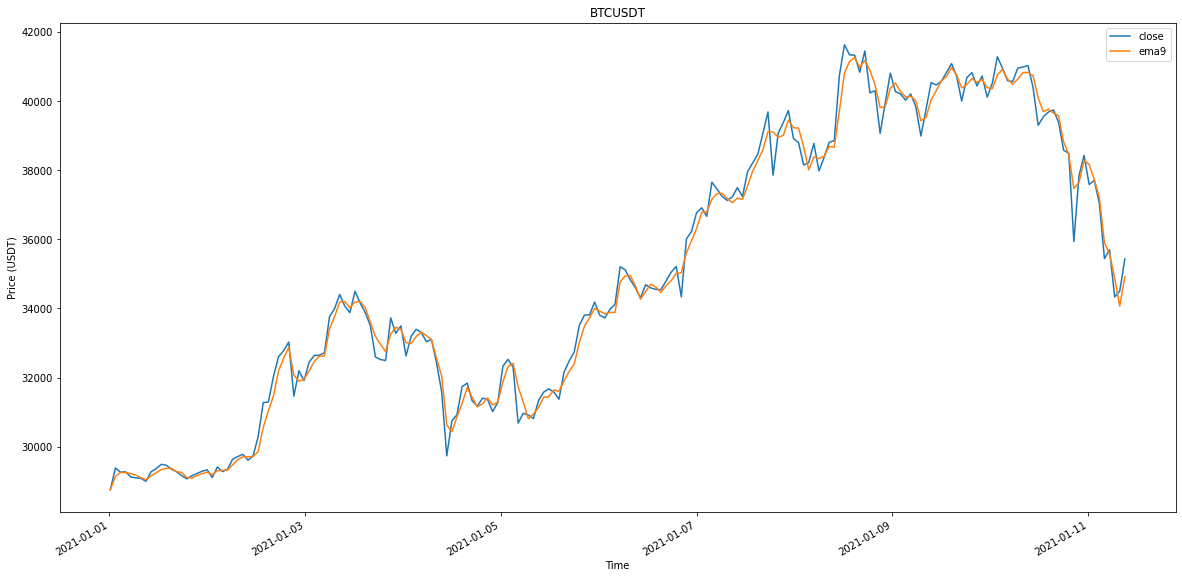

In [6]:
plot_sample_rate = 5
kline_df_ema = kline_df.assign(ema9 = TA.EMA(kline_df))
kline_df_ema[['close_time', 'close', 'ema9']].iloc[::plot_sample_rate, :].plot.line(x = 'close_time', figsize = (20, 10), title = 'BTCUSDT', xlabel = 'Time', ylabel = 'Price (USDT)')